In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

import os
import random
from pathlib import Path

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
def get_all_frames(root_dir='data'):
    ### Получаем все jpg файлы из всех подкаталогов frames ###
    all_frames = []
    
    for root, dirs, files in os.walk(root_dir):
        if os.path.basename(root) == 'frames':
            jpg_files = [os.path.join(root, f) for f in files if f.lower().endswith('.jpg')]
            all_frames.extend(jpg_files)
    
    if not all_frames:
        raise ValueError("Не найдено ни одного jpg файла в структуре каталогов")
    
    return all_frames

all_frames = get_all_frames('/mnt/vol0/datasets/egowalk/traverse')

In [4]:
try:
	random_frame = random.choice(all_frames)
	print(f"Случайный кадр: {random_frame}")
except ValueError as e:
	print(e)

Случайный кадр: /mnt/vol0/datasets/egowalk/traverse/frames/2024_08_16__19_40_59__1723826550423.jpg


In [5]:
image = cv2.imread(random_frame)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

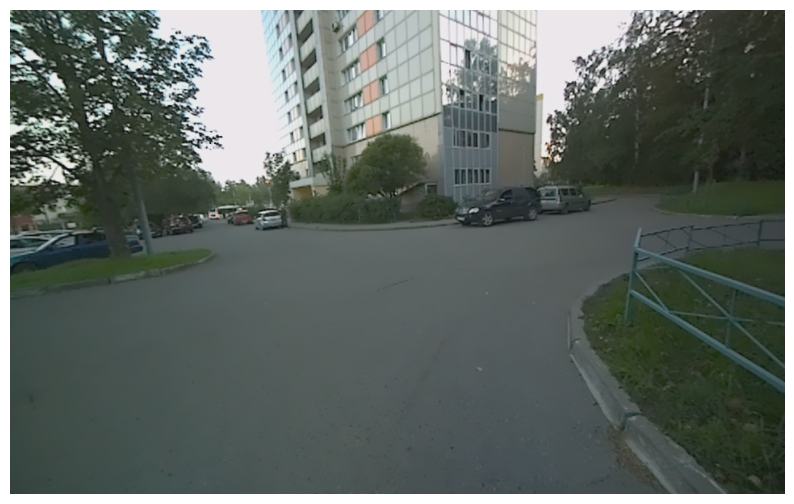

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/home/denis_fatykhov/segmentation/sam/sam-weight/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/home/denis_fatykhov/miniconda3/envs/sam/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

In [8]:
masks = mask_generator.generate(image)

In [9]:
print(len(masks))
print(masks[0].keys())

86
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


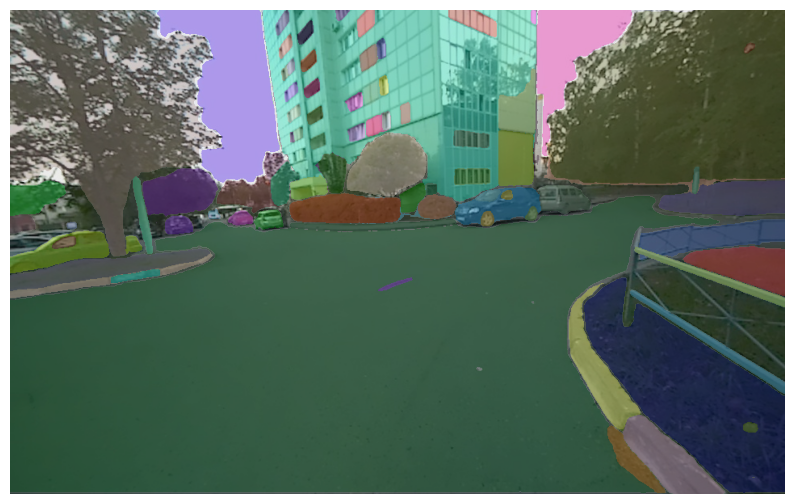

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 